### 1: load the Data
### 2: Convert to pytorch tensor


# 1. IMPORT LIBRARIES
# ==========================================

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import models, transforms
from PIL import Image

# 2. LOAD DATASET
# ==========================================

In [ ]:
df = pd.read_csv("/content/fmnist_small.csv")
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (6000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


# 3. EDA (Exploratory Data Analysis)
# ==========================================

In [ ]:
# Check missing values
print(f"Missing values: {df.isnull().sum().sum()}")

Missing values: 0


In [ ]:
x = df.drop(columns=['label'])
y = df['label']



/tmp/ipython-input-4067900163.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


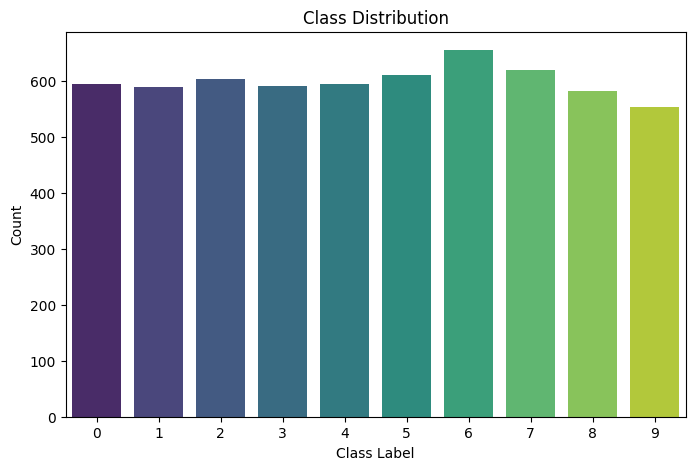

In [ ]:
# Class distribution
plt.figure(figsize=(8,5))
sns.countplot(x=y, palette='viridis')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

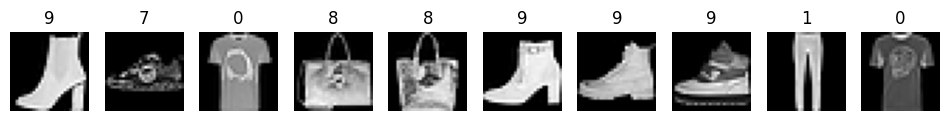

In [ ]:
# Show sample images
def show_samples(images, y, n=10):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].reshape(28,28), cmap='gray')
        plt.title(y[i])
        plt.axis('off')
    plt.show()

show_samples(x.values, y.values, n=10)

# 4. Train test split
# ==========================================

In [ ]:
# for putorch model it should be must to convert the datafram data into pytorch tensor (numpy array) becuse for fast caculation

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert features and labels to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

X_train

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., 16.,  0.,  0.]])

# 4. Transform
# ==========================================

### 1️⃣ What is a transformation?(A module that contain mani classes like resize, centercrop, normalize etc)
##### A transformation is simply an operation you apply to your input data before feeding it into a model.In torchvision.transforms, it’s usually used for images, but in general, transformations are just preprocessing steps

### 2️⃣ Why we use transformations
We use them to:

Resize / reshape data so it fits the model input size.

Convert formats (like images → tensors).

Normalize data so pixel values are on a standard scale.

Augment data (random flips, rotations) to make the model generalize better.

In [ ]:
custom_transform = transforms.Compose([
    transforms.Resize(256),                     # 1. Resize image so smaller edge = 256px
    transforms.CenterCrop(224),                 # 2. Crop center 224×224 (ImageNet models expect this)
    transforms.ToTensor(),                      # 3. Convert from PIL Image to PyTorch Tensor [0,1]
    transforms.Normalize(                        # 4. Normalize using ImageNet mean/std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# 5 CUSTOM DATASET
# ==========================================

In [ ]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, features, labels, transform):
    # Assign features and labels directly (now tensors)
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize to (28, 28)
    image = self.features[index].reshape(28,28)

    # change datatype to np.uint8
    image = image.numpy().astype(np.uint8)

    # change black&white to color -> (H,W,C) -> (C,H,W)
    image = np.stack([image]*3, axis=-1)

    # convert array to PIL image
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return
    return image, torch.tensor(self.labels[index], dtype=torch.long)

# 7. DATALOADERS
# ==========================================

In [ ]:
train_dataset = CustomDataset(X_train, y_train, transform=custom_transform)
test_dataset = CustomDataset(X_test, y_test, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# 8. LOAD PRE-TRAINED RESNET50
# ==========================================

In [ ]:
# fetch the pretrained model

import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)
vgg16

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 140MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Information about the vgg16 archetecture :

25088 = comes from the feature map size after the convolutional + pooling layers:

7
×
7
×
512
=
25088

7×7×512=25088
This part is fixed by your input image size and the network’s convolutional structure.

Feature extractor output (25088) = the number of inputs going into this dense layer.

4096 = the number of neurons in this layer, so each neuron learns a different combination of the 25088 input features.

Each neuron has 25088 weights + 1 bias, so the total parameters for this layer are:

25088
×
4096
+
4096
=
102
,
764
,
544
25088×4096+4096=102,764,544
That’s over 102 million parameters just for this single layer 😅 — no wonder VGG16 is heavy.


📏 Step-by-step size tracking for VGG16
We start with input image:
224 × 224 × 3

Block 1
Conv1: 3 → 64 filters, padding=1, stride=1 → size stays 224 × 224 × 64

Conv2: 64 → 64, padding=1 → size stays 224 × 224 × 64

MaxPool: kernel=2, stride=2 → 112 × 112 × 64

Block 2
Conv3: 64 → 128 → size 112 × 112 × 128

Conv4: 128 → 128 → size 112 × 112 × 128

MaxPool → 56 × 56 × 128

Block 3
Conv5: 128 → 256 → 56 × 56 × 256

Conv6: 256 → 256 → 56 × 56 × 256

Conv7: 256 → 256 → 56 × 56 × 256

MaxPool → 28 × 28 × 256

Block 4
Conv8: 256 → 512 → 28 × 28 × 512

Conv9: 512 → 512 → 28 × 28 × 512

Conv10: 512 → 512 → 28 × 28 × 512

MaxPool → 14 × 14 × 512

Block 5
Conv11: 512 → 512 → 14 × 14 × 512

Conv12: 512 → 512 → 14 × 14 × 512

Conv13: 512 → 512 → 14 × 14 × 512

MaxPool (your example layer) → 7 × 7 × 512

✅ So before your last MaxPool, the input to that layer is:
Height = 14, Width = 14, Depth = 512

After pooling with kernel=2, stride=2:
Output = 7 × 7 × 512

That’s why, when flattened:

7
×
7
×
512
=
25088
7×7×512=25088

Feature extractor output (25088) = the number of inputs going into this dense layer.

4096 = the number of neurons in this layer, so each neuron learns a different combination of the 25088 input features.

Each neuron has 25088 weights + 1 bias, so the total parameters for this layer are:

25088
×
4096
+
4096
=
102
,
764
,
544
25088×4096+4096=102,764,544
That’s over 102 million parameters just for this single layer 😅 — no wonder VGG16 is heavy.



## This is just information that how vgg model train on imagenet dataset with input size(224,224,3)

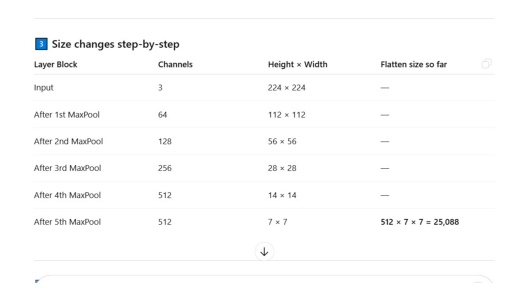

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img = Image.open('/content/WhatsApp Image 2025-08-12 at 12.32.12_01baaf54.jpg')

# Display the image
plt.imshow(img)
plt.axis('off') # Hide axes
plt.show()

How to Freeze More Layers
VGG16 has two main parts:

vgg16.features → convolutional layers (good to freeze)

vgg16.classifier → fully connected layers (usually trainable

In [ ]:
# Freeze all conv layers first
for param in vgg16.features.parameters():
  param.requires_grad=False


  # Unfreeze the last convolutional layer
#for param in vgg16.features[28].parameters():
 #   param.requires_grad = True


In [ ]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Dropout(0.8),
    nn.Linear(512, 10)
)


learning_rate = 0.0005
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

# Last Unfreez
# {"params": vgg16.features[28].parameters(), "lr": learning_rate * 0.05},  # even smaller LR for conv layer

# 10. TRAINING LOOP
# ==========================================

Effect on Overfitting
Freeze more layers → fewer trainable parameters → less overfitting risk.

Freeze fewer layers → more adaptation to your dataset but higher overfitting risk.



In [ ]:
# training loop

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

train_acc = []
val_acc = []

for epoch in range(epochs):

  total_epoch_loss = 0
  correct_train = 0
  total_train = 0

  vgg16.train() # Set model to training mode

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = vgg16(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total_train += batch_labels.size(0)
    correct_train += (predicted == batch_labels).sum().item()


  # Calculate training accuracy
  train_accuracy = 100 * correct_train / total_train
  train_acc.append(train_accuracy)


  # Evaluate on validation data
  vgg16.eval() # Set model to evaluation mode
  correct_val = 0
  total_val = 0
  with torch.no_grad():
      for batch_features, batch_labels in test_loader: # Assuming test_loader is for validation
          batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
          outputs = vgg16(batch_features)
          _, predicted = torch.max(outputs.data, 1)
          total_val += batch_labels.size(0)
          correct_val += (predicted == batch_labels).sum().item()

  val_accuracy = 100 * correct_val / total_val
  val_acc.append(val_accuracy)


  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

/tmp/ipython-input-748920540.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(self.labels[index], dtype=torch.long)


Epoch [1/25], Loss: 0.7865, Train Acc: 73.81%, Val Acc: 86.25%
Epoch [2/25], Loss: 0.4929, Train Acc: 82.90%, Val Acc: 86.00%
Epoch [3/25], Loss: 0.4057, Train Acc: 85.19%, Val Acc: 87.67%
Epoch [4/25], Loss: 0.3493, Train Acc: 87.50%, Val Acc: 88.75%
Epoch [5/25], Loss: 0.3125, Train Acc: 89.02%, Val Acc: 89.00%
Epoch [6/25], Loss: 0.2569, Train Acc: 90.50%, Val Acc: 88.67%
Epoch [7/25], Loss: 0.2607, Train Acc: 90.73%, Val Acc: 89.08%
Epoch [8/25], Loss: 0.2499, Train Acc: 91.54%, Val Acc: 89.08%
Epoch [9/25], Loss: 0.2220, Train Acc: 91.83%, Val Acc: 89.17%
Epoch [10/25], Loss: 0.1805, Train Acc: 93.73%, Val Acc: 89.33%
Epoch [11/25], Loss: 0.1910, Train Acc: 93.00%, Val Acc: 89.92%
Epoch [12/25], Loss: 0.1837, Train Acc: 93.29%, Val Acc: 89.33%
Epoch [13/25], Loss: 0.1766, Train Acc: 93.96%, Val Acc: 89.42%
Epoch [14/25], Loss: 0.1710, Train Acc: 94.29%, Val Acc: 89.25%
Epoch [15/25], Loss: 0.1749, Train Acc: 94.06%, Val Acc: 89.75%
Epoch [16/25], Loss: 0.1664, Train Acc: 94.15%, V

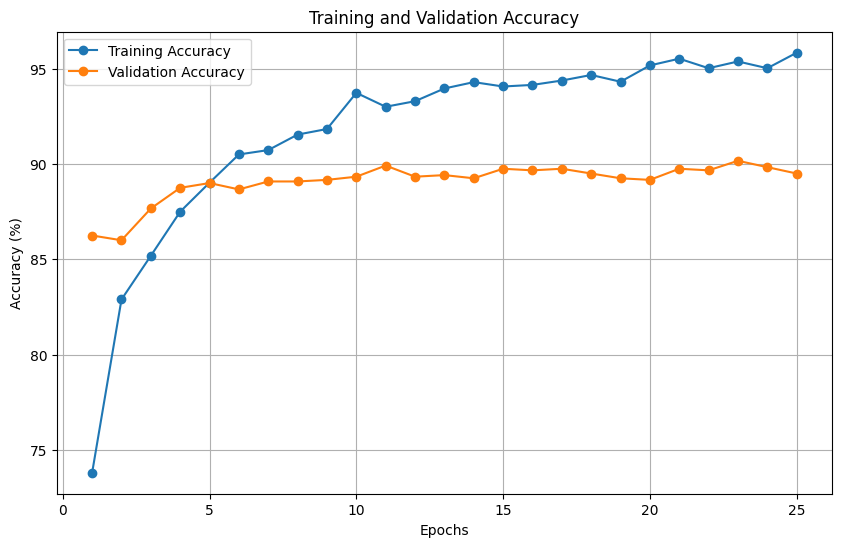

In [ ]:
import matplotlib.pyplot as plt

# After training loop completes:

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs_range, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


# Resnet 18 :

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# Load pretrained ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the final fully connected layer for 10 classes (Fashion MNIST)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(512, 10)
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

# Define loss and optimizer (only train resnet18.fc parameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.0005)

train_acc = []
val_acc = []

for epoch in range(epochs):

    total_epoch_loss = 0
    correct_train = 0
    total_train = 0

    resnet18.train()  # Set model to training mode

    for batch_features, batch_labels in train_loader:

        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = resnet18(batch_features)

        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_labels.size(0)
        correct_train += (predicted == batch_labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)

    resnet18.eval()  # Set model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:  # Use test_loader for validation data
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = resnet18(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            total_val += batch_labels.size(0)
            correct_val += (predicted == batch_labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_acc.append(val_accuracy)

    avg_loss = total_epoch_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]
/tmp/ipython-input-748920540.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(self.labels[index], dtype=torch.long)


Epoch [1/25], Loss: 1.4282, Train Acc: 50.21%, Val Acc: 75.67%
Epoch [2/25], Loss: 0.8826, Train Acc: 70.04%, Val Acc: 77.50%
Epoch [3/25], Loss: 0.7589, Train Acc: 73.52%, Val Acc: 77.75%
Epoch [4/25], Loss: 0.6953, Train Acc: 75.83%, Val Acc: 79.08%
Epoch [5/25], Loss: 0.6494, Train Acc: 77.15%, Val Acc: 78.83%
Epoch [6/25], Loss: 0.6249, Train Acc: 78.60%, Val Acc: 79.42%
Epoch [7/25], Loss: 0.5979, Train Acc: 78.69%, Val Acc: 80.50%
Epoch [8/25], Loss: 0.5756, Train Acc: 79.40%, Val Acc: 80.17%
Epoch [9/25], Loss: 0.5686, Train Acc: 79.67%, Val Acc: 80.83%
Epoch [10/25], Loss: 0.5500, Train Acc: 80.33%, Val Acc: 81.08%
Epoch [11/25], Loss: 0.5365, Train Acc: 80.60%, Val Acc: 81.50%
Epoch [12/25], Loss: 0.5296, Train Acc: 80.69%, Val Acc: 81.92%
Epoch [13/25], Loss: 0.4924, Train Acc: 82.12%, Val Acc: 81.58%
Epoch [14/25], Loss: 0.4914, Train Acc: 82.17%, Val Acc: 81.42%
Epoch [15/25], Loss: 0.4835, Train Acc: 82.58%, Val Acc: 81.83%
Epoch [16/25], Loss: 0.4760, Train Acc: 82.60%, V

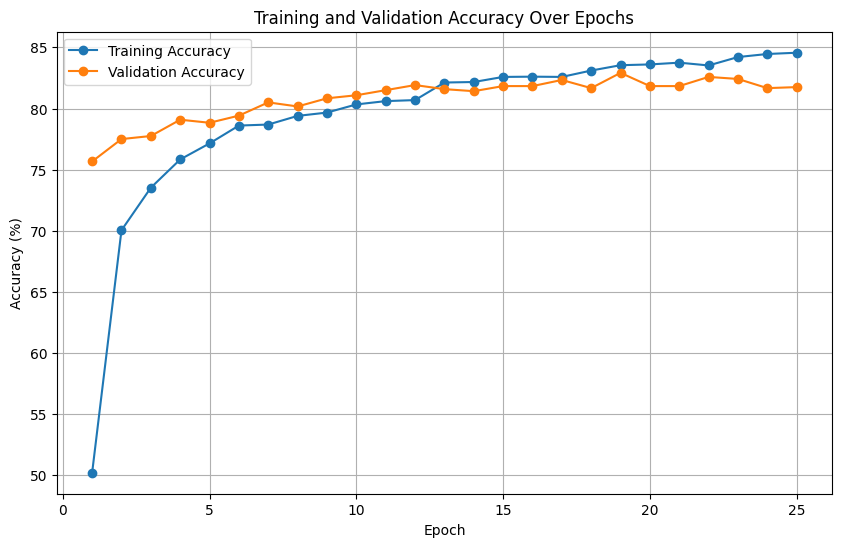

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_acc, marker='o', label='Training Accuracy')
plt.plot(epochs_range, val_acc, marker='o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


# Evaluation on test data :
============================================

In [ ]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

/tmp/ipython-input-748920540.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(self.labels[index], dtype=torch.long)


0.895


# 13. SAVE MODEL
# ==========================================

In [ ]:
torch.save(model.state_dict(), "fmnist_resnet50.pth")

NameError: name 'model' is not defined